# Laboratorio 4
## Clasificación de tweets usando minería de texto
### Integrantes:
### Pablo Escobar - 20936
### Eduardo

In [107]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

In [108]:
train_file = "./data/train.csv"

# read file
train_data = pd.read_csv(train_file)

train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Limpieza de datos

In [109]:
# remove caracters like @, ", '
caracters = ['@', '"', "'",'#','&','?','-']

for caracter in caracters:
    train_data['text'] = train_data['text'].str.replace(caracter, '')
    train_data['keyword'] = train_data['keyword'].str.replace(caracter, '')
    train_data['location'] = train_data['location'].str.replace(caracter, '')



In [110]:
# remove urls from text
import re
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

train_data['text'] = train_data['text'].apply(lambda x : remove_urls(x))




In [111]:
# get columns of type string
stringColumns = list(train_data.select_dtypes(include=['object']).columns)
print(stringColumns)

subfix = "_lowercase"
for column in stringColumns:
    train_data[column + subfix] = train_data[column].str.lower()



['keyword', 'location', 'text']


In [112]:
# remove stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

train_data['text_lowercase'] = train_data['text_lowercase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [113]:
# change nan to empty and add a column saying if the value was nan
for column in stringColumns:
    train_data[column + "_nan"] = train_data[column].isna()
    train_data[column] = train_data[column].fillna('empty')

train_data.head()

,id,keyword,location,text,target,keyword_lowercase,location_lowercase,text_lowercase,keyword_nan,location_nan,text_nan
0,1,empty,empty,Our Deeds are the Reason of this earthquake Ma...,1,NaN,NaN,deeds reason earthquake may allah forgive us,True,True,False
1,4,empty,empty,Forest fire near La Ronge Sask. Canada,1,NaN,NaN,forest fire near la ronge sask. canada,True,True,False
2,5,empty,empty,All residents asked to shelter in place are be...,1,NaN,NaN,residents asked shelter place notified officer...,True,True,False
3,6,empty,empty,"13,000 people receive wildfires evacuation ord...",1,NaN,NaN,"13,000 people receive wildfires evacuation ord...",True,True,False
4,7,empty,empty,Just got sent this photo from Ruby Alaska as s...,1,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,True,True,False


In [114]:
# get the rows which target is 1
targetTrue = train_data[train_data['target'] == 1]
targetTrue.head()

# get the rows which target is 0
targetFalse = train_data[train_data['target'] == 0]
targetFalse.head()

,id,keyword,location,text,target,keyword_lowercase,location_lowercase,text_lowercase,keyword_nan,location_nan,text_nan
15,23,empty,empty,Whats up man,0,NaN,NaN,whats man,True,True,False
16,24,empty,empty,I love fruits,0,NaN,NaN,love fruits,True,True,False
17,25,empty,empty,Summer is lovely,0,NaN,NaN,summer lovely,True,True,False
18,26,empty,empty,My car is so fast,0,NaN,NaN,car fast,True,True,False
19,28,empty,empty,What a goooooooaaaaaal!!!!!!,0,NaN,NaN,goooooooaaaaaal!!!!!!,True,True,False


<Axes: >

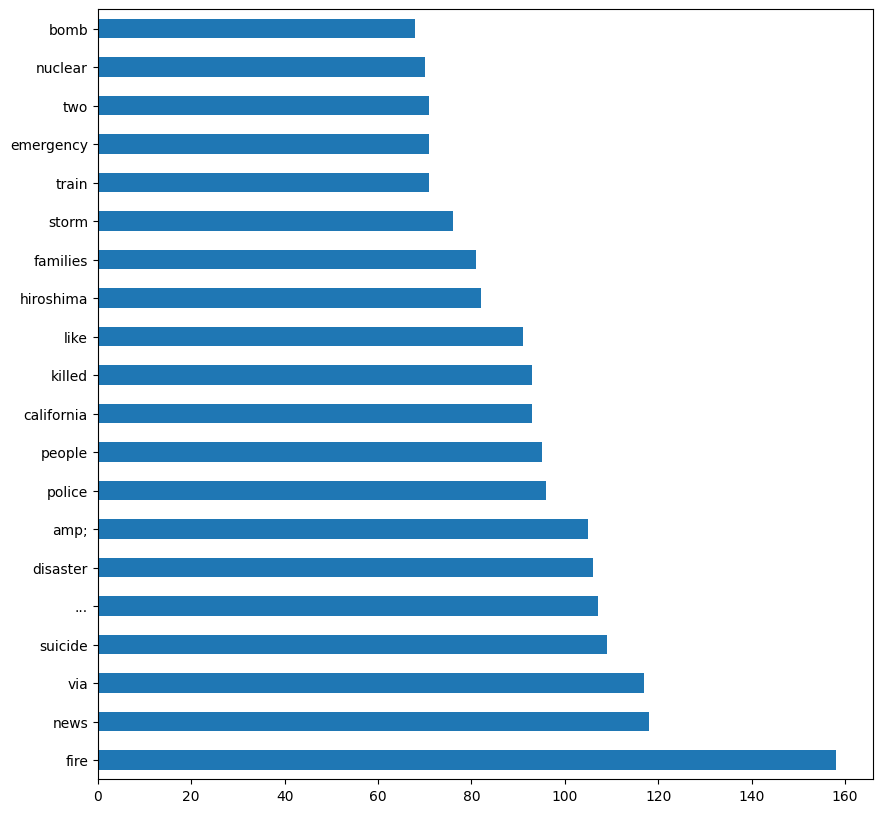

In [115]:
# get the frequency of each word in targetTrue
from collections import Counter
targetTrueWords = targetTrue['text_lowercase'].str.split(expand=True).stack().value_counts()

# plto the 20 most frequent words
targetTrueWords[:20].plot(kind='barh', figsize=(10, 10))



<Axes: >

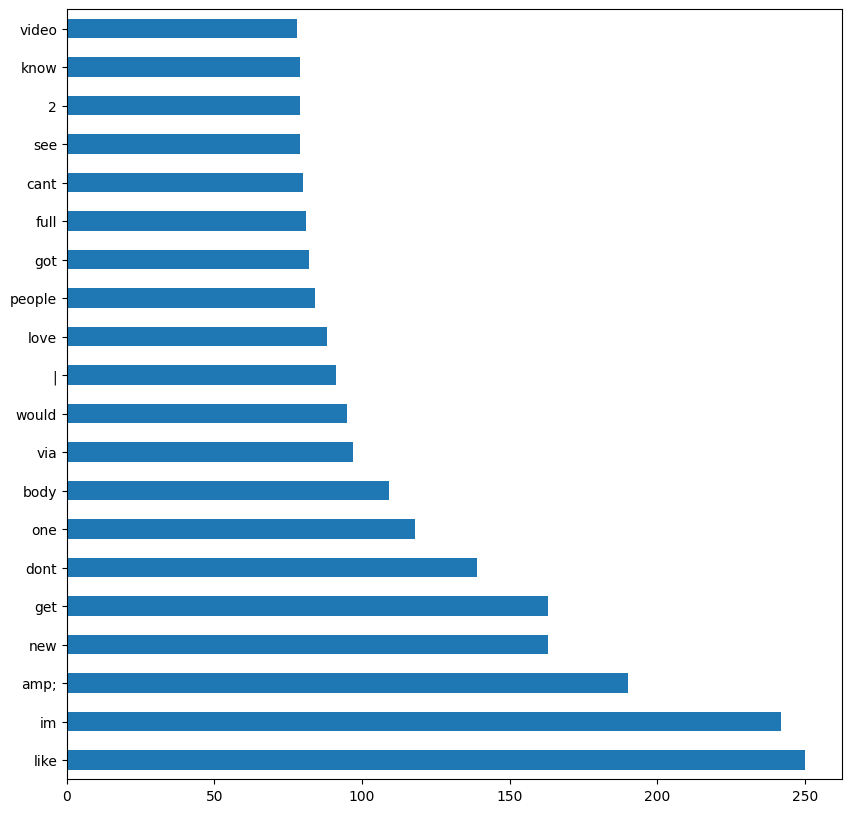

In [116]:
targetFalseWords = targetFalse['text_lowercase'].str.split(expand=True).stack().value_counts()

# plto the 20 most frequent words
targetFalseWords[:20].plot(kind='barh', figsize=(10, 10))

### ¿Qué palabras cree que le servirán para hacer un mejor modelo de clasificación?¿vale la pena explorar bigramas o trigramas para analizar contexto?

In [130]:
from nltk import word_tokenize
from nltk.util import ngrams

# bigrams
bigrams = ngrams(targetTrue['text_lowercase'].str.split(expand=True).stack(), 2)
countA =Counter(bigrams).most_common(20)
print(countA)

# trigrams
trigrams = ngrams(targetTrue['text_lowercase'].str.split(expand=True).stack(), 3)
countB =Counter(trigrams).most_common(20)
print(countB)

falseBigrams = ngrams(targetFalse['text_lowercase'].str.split(expand=True).stack(), 2)
countC =Counter(falseBigrams).most_common(20)
print(countC)

falseTrigrams = ngrams(targetFalse['text_lowercase'].str.split(expand=True).stack(), 3)
countD =Counter(falseTrigrams).most_common(20)
print(countD)


[(('suicide', 'bomber'), 59), (('northern', 'california'), 40), (('oil', 'spill'), 37), (('suicide', 'bombing'), 34), (('california', 'wildfire'), 33), (('burning', 'buildings'), 33), (('70', 'years'), 30), (('bomber', 'detonated'), 30), (('homes', 'razed'), 29), (('latest:', 'homes'), 28), (('razed', 'northern'), 28), (('16yr', 'old'), 28), (('pkk', 'suicide'), 28), (('detonated', 'bomb'), 28), (('severe', 'thunderstorm'), 27), (('old', 'pkk'), 27), (('debris', 'found'), 26), (('families', 'sue'), 26), (('40', 'families'), 26), (('families', 'affected'), 26)]
[(('suicide', 'bomber', 'detonated'), 30), (('northern', 'california', 'wildfire'), 28), (('latest:', 'homes', 'razed'), 28), (('homes', 'razed', 'northern'), 28), (('pkk', 'suicide', 'bomber'), 28), (('bomber', 'detonated', 'bomb'), 28), (('razed', 'northern', 'california'), 27), (('16yr', 'old', 'pkk'), 27), (('old', 'pkk', 'suicide'), 27), (('40', 'families', 'affected'), 26), (('families', 'affected', 'fatal'), 26), (('affect

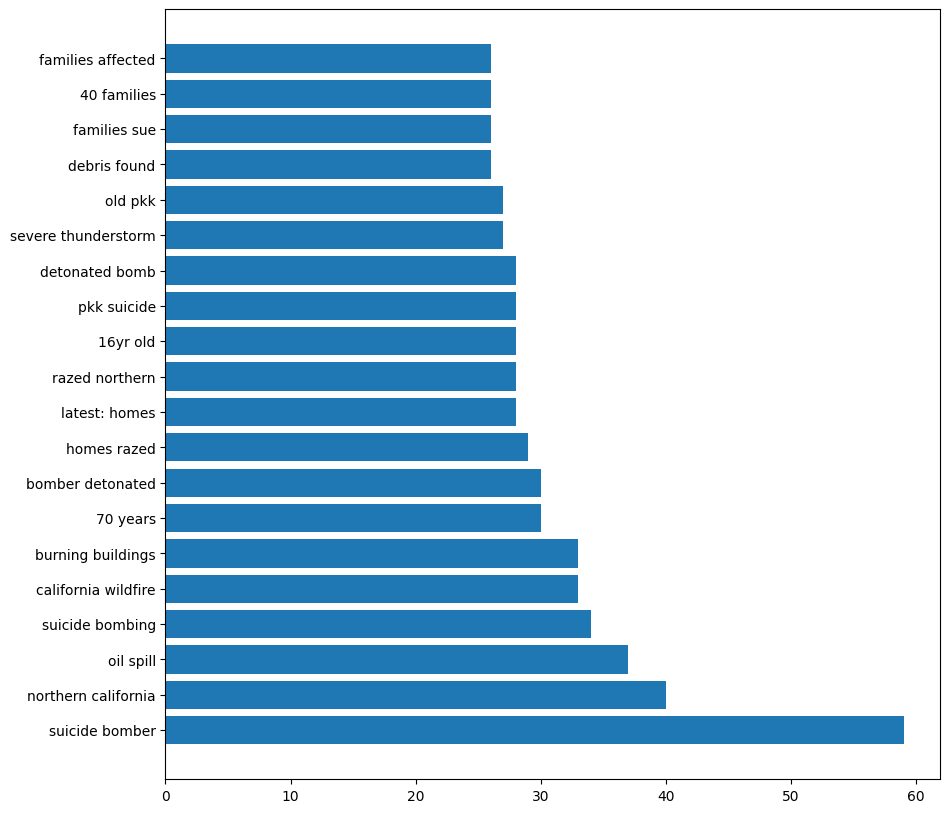

In [129]:
#  target true bigrams
x = [i[0] for i in countA]
x = [' '.join(i) for i in x]
y = [i[1] for i in countA]

plt.figure(figsize=(10, 10))
plt.barh(x, y)
plt.show()